# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_100 = final['Text'].values[100]
print(sent_100)
print("="*50)

sent_150 = final['Text'].values[150]
print(sent_150)
print("="*50)

sent_490 = final['Text'].values[490]
print(sent_490)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.
This dog toy has been a huge hit at my house. I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into. This toy is hard enough to hold up but not so hard he loses interest. The irregular shapes are great for giving him multiple chew spots on this toy. This dinosaur has even brought out the puppy i

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_100 = re.sub(r"http\S+", "", sent_100)
sent_150 = re.sub(r"http\S+", "", sent_150)
sent_490 = re.sub(r"http\S+", "", sent_490)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_100, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_150, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_490, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.
This dog toy has been a huge hit at my house. I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into. This toy is hard enough to hold up but not so hard he loses interest. The irregular shapes are great for giving him multiple chew spots on this toy. This dinosaur has even brought out the puppy i

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_150)
print(sent_150)
print("="*50)

This dog toy has been a huge hit at my house. I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into. This toy is hard enough to hold up but not so hard he loses interest. The irregular shapes are great for giving him multiple chew spots on this toy. This dinosaur has even brought out the puppy in my 8yr old mix that was never big on chew toys.<br />Can't go wrong with this one!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_150 = re.sub('[^A-Za-z0-9]+', ' ', sent_150)
print(sent_150)

This dog toy has been a huge hit at my house I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into This toy is hard enough to hold up but not so hard he loses interest The irregular shapes are great for giving him multiple chew spots on this toy This dinosaur has even brought out the puppy in my 8yr old mix that was never big on chew toys br Can t go wrong with this one 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2507.96it/s]


In [23]:
preprocessed_reviews[990]

'hard eat awesome product fast shipping smell awesome not younger kids since harder candy yo loves'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

(87773,)
(87773,)
(58807,) (58807,)
(28966,) (28966,)
[0 1] [ 9555 49252]
[0 1] [ 4626 24340]
(58807, 45480) (58807,)
(28966, 45480) (28966,)
best esitmator SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8859196395931032


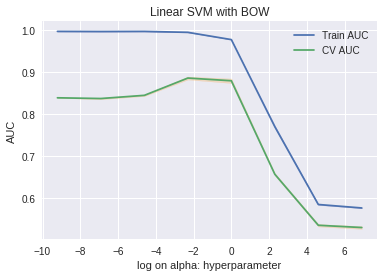

In [83]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

X=np.asarray(preprocessed_reviews)
Y=np.asarray(final['Score'])
print(X.shape)
print(Y.shape)

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33)


print(X_train.shape,Y_train.shape)

print(X_test.shape,Y_test.shape)
print("="*100)

unique1, counts1 = np.unique(Y_train, return_counts=True)
print(unique1,counts1)

unique2, counts2 = np.unique(Y_test, return_counts=True)
print(unique2,counts2)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

Vectorizer=CountVectorizer()
Vectorizer.fit(X_train)

X_train_bow=Vectorizer.transform(X_train)
X_test_bow=Vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow=scaler.fit_transform(X_test_bow)

print(X_train_bow.shape, Y_train.shape)

print(X_test_bow.shape, Y_test.shape)
print("="*100)

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
lsvm=SGDClassifier(loss="hinge",random_state=42)
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

clf = GridSearchCV(lsvm, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_bow, Y_train)

print("best esitmator",clf.best_estimator_)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']


print(max(cv_auc))
plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log on alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Linear SVM with BOW")
plt.show()

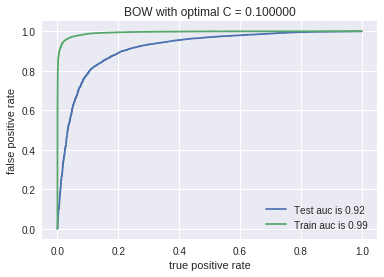

In [84]:
import sklearn.calibration
optimal_alpha=0.1
optimallsvm=SGDClassifier(loss="hinge",alpha=optimal_alpha,penalty="l2",class_weight="balanced")
optimallsvm.fit(X_train_bow,Y_train)
y_pred=optimallsvm.predict(X_test_bow)


CalibratedSVM=sklearn.calibration.CalibratedClassifierCV(base_estimator=optimallsvm,method='sigmoid')
CalibratedSVM.fit(X_train_bow,Y_train)


Y_test_proba=CalibratedSVM.predict_proba(X_test_bow)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=CalibratedSVM.predict_proba(X_train_bow)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)

plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('BOW with optimal C = %f' %optimal_alpha)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion marix for train_data BOW for optimal alpha = 0.100000')

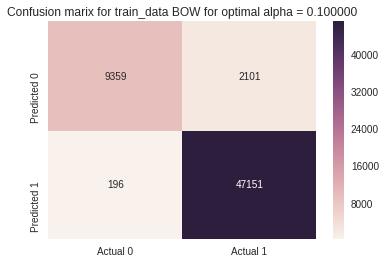

In [85]:
ax = sns.heatmap(confusion_matrix(Y_train,optimallsvm.predict(X_train_bow)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for train_data BOW for optimal alpha = %f' %optimal_alpha)

Text(0.5, 1.0, 'Confusion marix for train_data BOW for optimal apha = 0.100000')

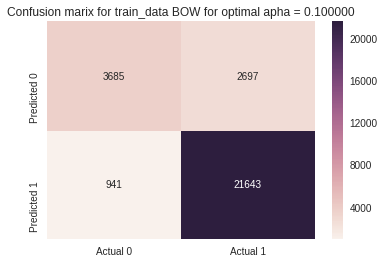

In [86]:
ax = sns.heatmap(confusion_matrix(Y_test,optimallsvm.predict(X_test_bow)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for train_data BOW for optimal apha = %f' %optimal_alpha)

In [87]:
feature_names=Vectorizer.get_feature_names()
top_pos=optimallsvm.coef_[0].argsort()
top_weights=optimallsvm.coef_[0]
#print(top_weights)
#print(top_pos[:-20:-1])
print("Top 20 important features of positve class are")
print(np.take(feature_names,top_pos[:-20:-1]))

Top 20 important features of positve class are
['great' 'best' 'love' 'good' 'delicious' 'loves' 'excellent' 'perfect'
 'wonderful' 'nice' 'favorite' 'highly' 'tasty' 'amazing' 'easy' 'yummy'
 'find' 'snack' 'smooth']


In [88]:
feature_names=Vectorizer.get_feature_names()
top_=optimallsvm.coef_[0].argsort()
top_weights=optimallsvm.coef_[0]
#print(top_pos[1:20:1])
print("Top 20 important features of negative class are")
print(np.take(feature_names,top_pos[1:20:1]))

Top 20 important features of negative class are
['disappointed' 'terrible' 'worst' 'bland' 'awful' 'horrible' 'thought'
 'disappointing' 'bad' 'money' 'stick' 'stale' 'weak' 'hoping'
 'unfortunately' 'ok' 'would' 'waste' 'taste']


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

(58807, 45480) (58807,)
(28966, 45480) (28966,)
best esitmator SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8859196395931032


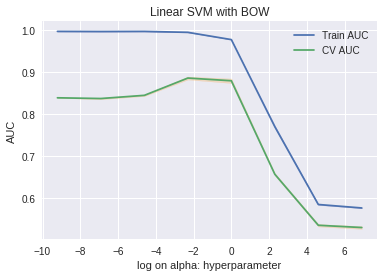

In [90]:
# Please write all the code with proper documentation
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_vect.fit(X_train)

X_train_tfidf=tfidf_vect.transform(X_train)
X_test_tfidf=tfidf_vect.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_tfidf = scaler.fit_transform(X_train_bow)
X_test_tfidf=scaler.fit_transform(X_test_bow)


print(X_train_tfidf.shape, Y_train.shape)
print(X_test_tfidf.shape, Y_test.shape)
print("="*100)

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
lsvm=SGDClassifier(loss="hinge",random_state=42)
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

clf = GridSearchCV(lsvm, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tfidf, Y_train)

print("best esitmator",clf.best_estimator_)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(max(cv_auc))
plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log on alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Linear SVM with BOW")
plt.show()

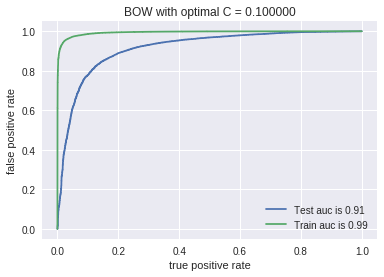

In [91]:
import sklearn.calibration
optimal_alpha=0.1
optimallsvm=SGDClassifier(loss="hinge",alpha=optimal_alpha,penalty="l2",class_weight="balanced")
optimallsvm.fit(X_train_tfidf,Y_train)
y_pred=optimallsvm.predict(X_test_tfidf)

CalibratedSVM=sklearn.calibration.CalibratedClassifierCV(base_estimator=optimallsvm,method='sigmoid')
CalibratedSVM.fit(X_train_tfidf,Y_train)

Y_test_proba=CalibratedSVM.predict_proba(X_test_tfidf)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=CalibratedSVM.predict_proba(X_train_bow)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)

plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('BOW with optimal C = %f' %optimal_alpha)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion marix for train_data TFIDF for optimal alpha = 0.100000')

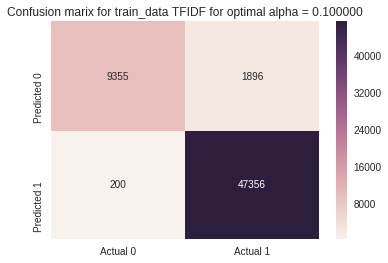

In [92]:
ax = sns.heatmap(confusion_matrix(Y_train,optimallsvm.predict(X_train_tfidf)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for train_data TFIDF for optimal alpha = %f' %optimal_alpha)

Text(0.5, 1.0, 'Confusion marix for test_data BOW for optimal apha = 0.100000')

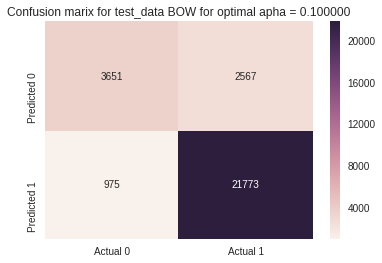

In [93]:
ax = sns.heatmap(confusion_matrix(Y_test,optimallsvm.predict(X_test_tfidf)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for test_data BOW for optimal apha = %f' %optimal_alpha)

In [94]:
feature_names=Vectorizer.get_feature_names()
top_pos=optimallsvm.coef_[0].argsort()
top_weights=optimallsvm.coef_[0]
#print(top_weights)
#print(top_pos[:-20:-1])
print("Top 20 important features of positve class are")
print(np.take(feature_names,top_pos[:-20:-1]))

Top 20 important features of positve class are
['great' 'best' 'good' 'love' 'delicious' 'loves' 'perfect' 'excellent'
 'nice' 'wonderful' 'favorite' 'highly' 'tasty' 'amazing' 'yummy' 'easy'
 'find' 'smooth' 'snack']


In [95]:
feature_names=Vectorizer.get_feature_names()
top_=optimallsvm.coef_[0].argsort()
top_weights=optimallsvm.coef_[0]
#print(top_pos[1:20:1])
print("Top 20 important features of negative class are")
print(np.take(feature_names,top_pos[1:20:1]))

Top 20 important features of negative class are
['disappointed' 'terrible' 'worst' 'horrible' 'thought' 'awful' 'bland'
 'disappointing' 'bad' 'unfortunately' 'weak' 'money' 'hoping'
 'disappointment' 'stale' 'waste' 'would' 'stick' 'ok']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [96]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14501
sample words  ['excellent', 'probiotics', 'plus', 'makes', 'delicious', 'yogurt', 'easy', 'make', 'yougurt', 'without', 'artificial', 'additives', 'made', 'first', 'batch', 'turned', 'perfectly', 'used', 'organic', 'dry', 'milk', 'well', 'thicker', 'purchased', 'chocolate', 'could', 'eat', 'morning', 'noon', 'night', 'best', 'dark', 'ever', 'pleasure', 'buying', 'several', 'finicky', 'cats', 'absolutely', 'crazy', 'tartar', 'control', 'treats', 'part', 'healthy', 'highly', 'recommend', 'cat', 'parent', 'friend']


In [97]:
from tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
avgw2v_train = np.array(sent_vectors_train)
print(avgw2v_train.shape)
print(avgw2v_train[0])

100%|██████████| 58807/58807 [01:59<00:00, 491.60it/s]


(58807, 50)
[ 0.774747    0.54146137 -0.38198882 -0.03719013 -0.49067549  0.9341522
 -0.44340321 -0.16804559 -0.0338848  -0.06884673 -0.34784149 -0.01365368
  1.50247385  1.22165359 -0.42932435  0.30695996 -0.86898182 -0.36886864
 -0.18436319 -0.12716376 -0.19221861  0.21182716 -0.60095721 -0.04270602
 -0.63590388 -0.02022929 -0.49982439  0.28913633  0.70086652  0.13927729
  0.20002782 -0.2834855  -0.4146306   0.86197949 -0.05741413  0.4818645
 -0.18116237  0.69446096 -0.85078695 -0.33360452 -0.03177095  0.3082564
 -0.15250703 -0.81528185  0.16856471 -0.49665641 -0.19376227  0.12273296
  0.06505889  0.08190278]


In [98]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
avgw2v_test = np.array(sent_vectors_test)
print(avgw2v_test.shape)
print(avgw2v_test[0])

100%|██████████| 28966/28966 [00:57<00:00, 506.76it/s]

(28966, 50)
[-0.26226746 -0.25854095  0.17689265 -0.09721897 -0.33019479  0.64669582
  0.32548305 -0.11308181 -0.22659454 -0.34884094 -0.5134693   0.26992225
  0.11403421  0.5674176   0.14517495  0.0370194  -0.17967233 -0.00904847
 -0.27463067 -0.23238119 -0.47870202 -0.19916578 -0.07908419  0.32192801
 -0.43675284  0.07064957 -0.10829788  0.0140943  -0.12850866 -0.10603196
 -0.07722666 -0.07873672  0.52964229  0.09517652  0.14496416  0.63113271
  0.33589899 -0.06078671 -0.1937399   0.22784706  0.26898138 -0.28331918
  0.06448873 -0.07164346  0.15864838  0.21317512 -0.23341315  0.31543507
  0.27939972 -0.16484437]


best esitmator SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.9026623157430731


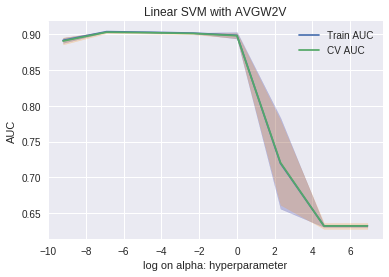

In [39]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
lsvm=SGDClassifier(loss="hinge",random_state=42)
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

clf = GridSearchCV(lsvm, parameters, cv=3, scoring='roc_auc')
clf.fit(avgw2v_train, Y_train)

print("best esitmator",clf.best_estimator_)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
print(max(cv_auc))
plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log on alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Linear SVM with AVGW2V")
plt.show()

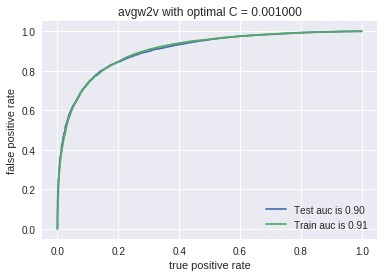

In [100]:
import sklearn.calibration
optimal_alpha=0.001
optimallsvm=SGDClassifier(loss="hinge",alpha=optimal_alpha,penalty="l2",class_weight="balanced")
optimallsvm.fit(avgw2v_train,Y_train)
y_pred=optimallsvm.predict(avgw2v_test)

CalibratedSVM=sklearn.calibration.CalibratedClassifierCV(base_estimator=optimallsvm,method='sigmoid')
CalibratedSVM.fit(avgw2v_train,Y_train)

Y_test_proba=CalibratedSVM.predict_proba(avgw2v_test)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=CalibratedSVM.predict_proba(avgw2v_train)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)

plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('avgw2v with optimal C = %f' %optimal_alpha)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion marix for train_data TFIDF for optimal alpha = 0.001000')

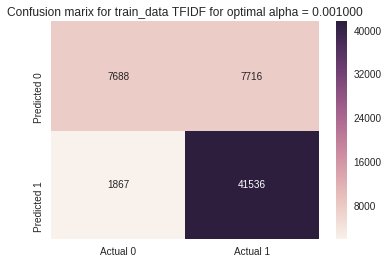

In [101]:
ax = sns.heatmap(confusion_matrix(Y_train,optimallsvm.predict(avgw2v_train)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for train_data TFIDF for optimal alpha = %f' %optimal_alpha)

Text(0.5, 1.0, 'Confusion marix for test_data avgw2v for optimal apha = 0.001')

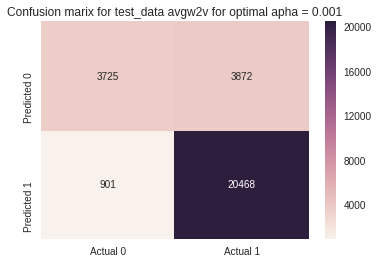

In [102]:
ax = sns.heatmap(confusion_matrix(Y_test,optimallsvm.predict(avgw2v_test)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for test_data avgw2v for optimal apha = {0}'.format(optimal_alpha))

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [103]:
# Please write all the code with proper documentation
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidfw2v_train=np.array(tfidf_sent_vectors)
print(tfidfw2v_train.shape)
print(tfidfw2v_train[0])


100%|██████████| 58807/58807 [26:09<00:00, 37.48it/s]

(58807, 50)
[ 0.88568498  0.34827055 -0.280589    0.04480426 -0.79867636  0.98054224
 -0.38730822 -0.03544312  0.08079386 -0.16076404 -0.20724662 -0.27643534
  1.45545565  1.23858234 -0.45707559  0.14117487 -0.81595733 -0.68339455
 -0.03858223 -0.12841156 -0.44457432  0.07852719 -0.83264561  0.15903654
 -0.7810696  -0.05621576 -0.32119267  0.44433566  0.71191641  0.22855813
  0.35035376 -0.45016081 -0.46789804  0.98921522 -0.02105032  0.2829314
 -0.07448897  0.57194145 -0.79736313 -0.578062   -0.09960319  0.16650786
 -0.16950128 -0.79389406  0.18032752 -0.63958681 -0.18553817 -0.06613022
  0.04136092  0.14207297]


In [109]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidfw2v_test=np.array(tfidf_sent_vectors)
print(tfidfw2v_test.shape)
print(tfidfw2v_test[0])

100%|██████████| 28966/28966 [12:51<00:00, 26.36it/s]

(28966, 50)
[-0.2455648  -0.11798649  0.12817512 -0.11562933 -0.34245068  0.46516344
  0.25148142 -0.06396902 -0.19065357 -0.24295563 -0.41951184  0.16391171
  0.134822    0.48202474  0.11385623 -0.03646728 -0.11226007 -0.09837171
 -0.21719138 -0.21181183 -0.36215345 -0.13514865 -0.02470404  0.26262621
 -0.3981277   0.06372812  0.01594862  0.00909906 -0.11823467 -0.07832878
 -0.09300592 -0.06979231  0.4061503   0.07090607  0.13771418  0.49388208
  0.19497678 -0.09678868 -0.1663341   0.20450523  0.24571861 -0.21160643
  0.07474489 -0.02073603  0.0658102   0.16086404 -0.19769903  0.1876423
  0.23439282 -0.06129088]


In [110]:
tfidfw2v_test.shape

(28966, 50)

best esitmator SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8761723780949734


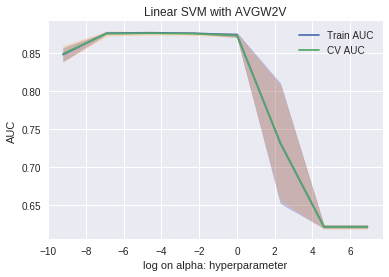

In [45]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
lsvm=SGDClassifier(loss="hinge",random_state=42)
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

clf = GridSearchCV(lsvm, parameters, cv=3, scoring='roc_auc')
clf.fit(tfidfw2v_train, Y_train)

print("best esitmator",clf.best_estimator_)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
print(max(cv_auc))
plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log on alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Linear SVM with AVGW2V")
plt.show()

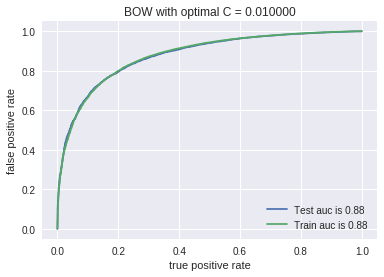

In [111]:
import sklearn.calibration
optimal_alpha=0.01
optimallsvm=SGDClassifier(loss="hinge",alpha=optimal_alpha,penalty="l2",class_weight="balanced")
optimallsvm.fit(tfidfw2v_train,Y_train)
y_pred=optimallsvm.predict(tfidfw2v_test)

CalibratedSVM=sklearn.calibration.CalibratedClassifierCV(base_estimator=optimallsvm,method='sigmoid')
CalibratedSVM.fit(tfidfw2v_train,Y_train)

Y_test_proba=CalibratedSVM.predict_proba(tfidfw2v_test)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=CalibratedSVM.predict_proba(tfidfw2v_train)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)
plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('BOW with optimal C = %f' %optimal_alpha)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion marix for train_data tfidfw2v for optimal alpha = 0.010000')

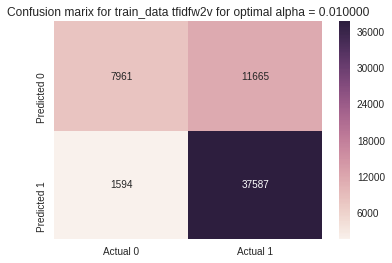

In [112]:
ax = sns.heatmap(confusion_matrix(Y_train,optimallsvm.predict(tfidfw2v_train)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for train_data tfidfw2v for optimal alpha = %f' %optimal_alpha)

Text(0.5, 1.0, 'Confusion marix for test_data tfidfw2v for optimal apha = 0.010000')

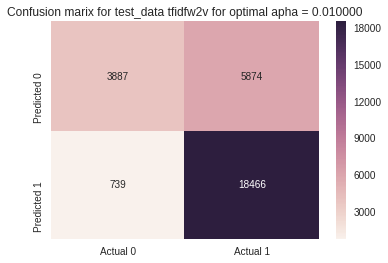

In [113]:
ax = sns.heatmap(confusion_matrix(Y_test,optimallsvm.predict(tfidfw2v_test)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion marix for test_data tfidfw2v for optimal apha = %f' %optimal_alpha)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [24]:
X=np.asarray(preprocessed_reviews[:20000])
Y=np.asarray(final['Score'][:20000])
print(X.shape)
print(Y.shape)

(20000,)
(20000,)


(8978,) (8978,)
(6600,) (6600,)
[0 1] [1361 7617]
[0 1] [1010 5590]
(8978, 500) (8978,)
(6600, 500) (6600,)
(4422, 500) (4422,)
0.885244661291192


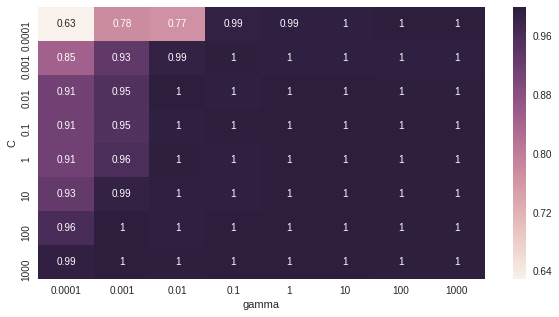

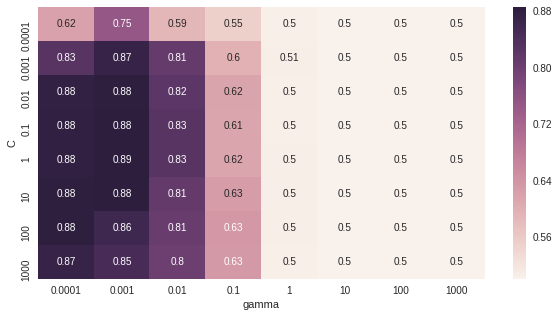

In [25]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.33)

print(X_train.shape,Y_train.shape)

print(X_test.shape,Y_test.shape)
print("="*100)

unique1, counts1 = np.unique(Y_train, return_counts=True)
print(unique1,counts1)

unique2, counts2 = np.unique(Y_test, return_counts=True)
print(unique2,counts2)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
Vectorizer=CountVectorizer(min_df=10,max_features=500)
Vectorizer.fit(X_train)

X_train_bow=Vectorizer.transform(X_train)
X_cv_bow=Vectorizer.transform(X_cv)
X_test_bow=Vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_cv_bow=scaler.fit_transform(X_cv_bow)
X_test_bow=scaler.fit_transform(X_test_bow)

print(X_train_bow.shape, Y_train.shape)

print(X_test_bow.shape, Y_test.shape)

print(X_cv_bow.shape, Y_cv.shape)
print("="*100)

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
gamma=[0.0001,0.001,0.01,0.1,1,10,100,1000]
train_auc=[]
cv_auc=[]


for i in C:
  for j in gamma:
      rbfsvm=SVC(C=i,gamma=j,kernel="rbf",random_state=42,probability=True)
      rbfsvm.fit(X_train_bow,Y_train)
      Y_train_predict=rbfsvm.predict_proba(X_train_bow)[:,1]
      Y_cv_predict=rbfsvm.predict_proba(X_cv_bow)[:,1]
      train_auc.append(roc_auc_score(Y_train,Y_train_predict))
      cv_auc.append(roc_auc_score(Y_cv,Y_cv_predict))

print(max(cv_auc))
data=np.array(train_auc)
data=data.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(data,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
cvdata=np.array(cv_auc)
cvdata=cvdata.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(cvdata,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

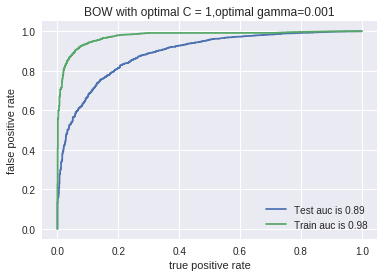

In [79]:
optimal_C=1
optimal_gamma=0.001
optimalrbfsvm=SVC(C=optimal_C,gamma=optimal_gamma,class_weight="balanced",kernel="rbf",random_state=42,probability=True)
optimalrbfsvm.fit(X_train_bow,Y_train)

Y_test_proba=optimalrbfsvm.predict_proba(X_test_bow)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=optimalrbfsvm.predict_proba(X_train_bow)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)

plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('BOW with optimal C = {0},optimal gamma={1}'.format(optimal_C,optimal_gamma))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix for train_data bow for optimal C = 1 and optimal gamma=0.001')

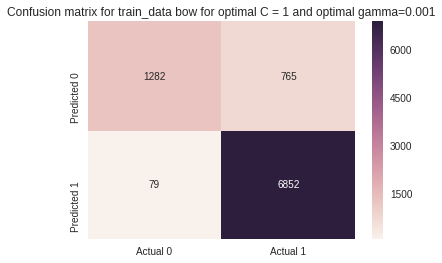

In [80]:
ax = sns.heatmap(confusion_matrix(Y_train,optimalrbfsvm.predict(X_train_bow)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for train_data bow for optimal C = {0} and optimal gamma={1}'.format(optimal_C,optimal_gamma))

Text(0.5, 1.0, 'Confusion matrix for train_data bow for optimal c=1 and optimal gamma=0.001')

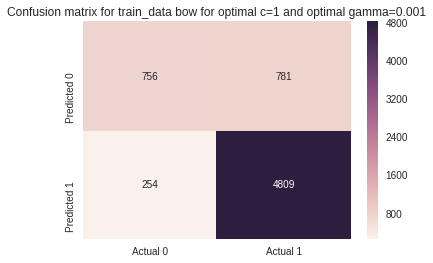

In [81]:
ax = sns.heatmap(confusion_matrix(Y_test,optimalrbfsvm.predict(X_test_bow)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for train_data bow for optimal c={0} and optimal gamma={1}'.format(optimal_C,optimal_gamma))

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [30]:
# Please write all the code with proper documentation
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
tfidf_vect.fit(X_train)

X_train_tfidf=tfidf_vect.transform(X_train)
X_test_tfidf=tfidf_vect.transform(X_test)
X_cv_tfidf=tfidf_vect.transform(X_cv)

scaler = StandardScaler(with_mean=False)
X_train_tfidf = scaler.fit_transform(X_train_bow)
X_test_tfidf=scaler.fit_transform(X_test_bow)
X_cv_tfidf=scaler.fit_transform(X_cv_bow)


print(X_train_tfidf.shape, Y_train.shape)
print(X_test_tfidf.shape, Y_test.shape)
print(X_test_tfidf.shape,Y_cv.shape)
print("="*100)

(8978, 500) (8978,)
(6600, 500) (6600,)
(6600, 500) (4422,)


0.885244661291192


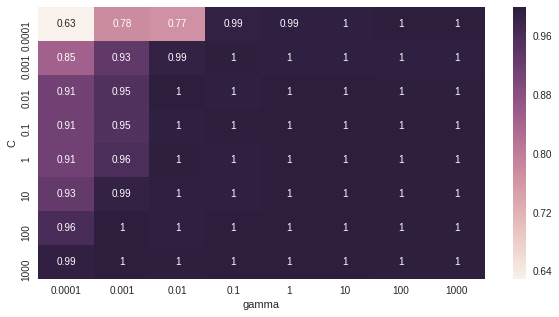

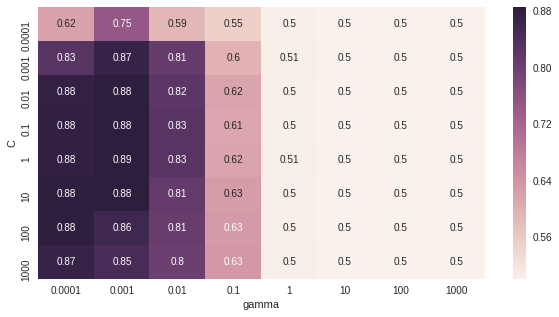

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
gamma=[0.0001,0.001,0.01,0.1,1,10,100,1000]
train_auc=[]
cv_auc=[]


for i in C:
  for j in gamma:
      rbfsvm=SVC(C=i,gamma=j,kernel="rbf",random_state=42,probability=True)
      rbfsvm.fit(X_train_tfidf,Y_train)
      Y_train_predict=rbfsvm.predict_proba(X_train_tfidf)[:,1]
      Y_cv_predict=rbfsvm.predict_proba(X_cv_tfidf)[:,1]
      train_auc.append(roc_auc_score(Y_train,Y_train_predict))
      cv_auc.append(roc_auc_score(Y_cv,Y_cv_predict))

print(max(cv_auc))
data=np.array(train_auc)
data=data.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(data,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
cvdata=np.array(cv_auc)
cvdata=cvdata.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(cvdata,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

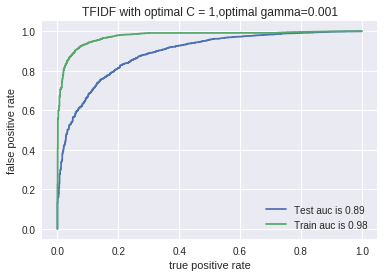

In [75]:
optimal_C=1
optimal_gamma=0.001
optimalrbfsvm=SVC(C=optimal_C,gamma=optimal_gamma,kernel="rbf",class_weight="balanced",random_state=42,probability=True)
optimalrbfsvm.fit(X_train_tfidf,Y_train)

Y_test_proba=optimalrbfsvm.predict_proba(X_test_bow)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=optimalrbfsvm.predict_proba(X_train_bow)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)

plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('TFIDF with optimal C = {0},optimal gamma={1}'.format(optimal_C,optimal_gamma))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix for train_data tfidf for optimal C = 1 and optimal gamma=0.001')

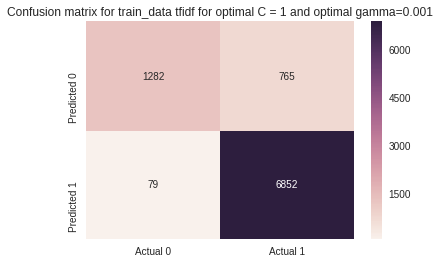

In [76]:
ax = sns.heatmap(confusion_matrix(Y_train,optimalrbfsvm.predict(X_train_tfidf)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for train_data tfidf for optimal C = {0} and optimal gamma={1}'.format(optimal_C,optimal_gamma))

Text(0.5, 1.0, 'Confusion matrix for test_data tfidf for optimal alpha = 1 optimal gamma =0.001')

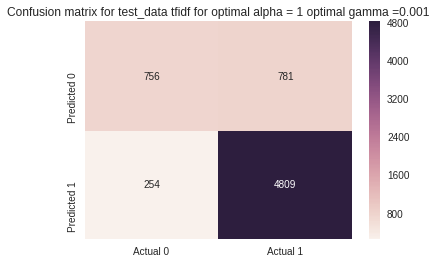

In [77]:
ax = sns.heatmap(confusion_matrix(Y_test,optimalrbfsvm.predict(X_test_tfidf)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for test_data tfidf for optimal alpha = {} optimal gamma ={}'.format(optimal_C,optimal_gamma))

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [39]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5537
sample words  ['mexican', 'drink', 'joint', 'fix', 'goat', 'milk', 'heat', 'open', 'yard', 'taste', 'awful', 'not', 'pleasing', 'like', 'thick', 'hot', 'chocolate', 'found', 'used', 'get', 'chili', 'mix', 'husband', 'worked', 'lived', 'la', 'would', 'visit', 'make', 'easy', 'delicious', 'cleveland', 'home', 'able', 'find', 'delighted', 'could', 'order', 'amazon', 'already', 'family', 'night', 'dinner', 'tonight', 'huge', 'hit', 'pack', 'share', 'members', 'bit']


In [40]:
from tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
avgw2v_train = np.array(sent_vectors_train)
print(avgw2v_train.shape)
print(avgw2v_train[0])

100%|██████████| 8978/8978 [00:09<00:00, 982.02it/s] 

(8978, 50)
[-0.30872781  0.16581486 -0.20173058 -0.43306531 -0.71893396  0.84346387
  0.10231058 -0.01548728 -0.42813659 -0.31107975 -0.84124882 -0.433589
  0.7988086   0.28331556  0.02294361 -0.31724644 -0.41581435 -0.78185667
 -0.16043389 -0.92236853  0.39556261  0.36352166 -0.17509111 -0.41562994
 -0.44579642  0.0084224   0.42800226  0.03794684 -0.19220871  0.44774324
  0.07641247  0.25009462  0.14258674  0.07101235  0.04667584  0.45370141
 -0.16430559  0.07351123 -0.50340344  0.3344444   0.40943279 -0.12230135
 -0.03606014 -0.54422481 -0.85949136  0.08636944 -0.19179218 -0.31932739
  0.02655978  0.42621345]


In [41]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
avgw2v_test = np.array(sent_vectors_test)
print(avgw2v_test.shape)
print(avgw2v_test[0])

100%|██████████| 6600/6600 [00:06<00:00, 949.23it/s]

(6600, 50)
[-0.60418279  0.50501935  0.11672106 -0.20728131 -0.77019582  0.4168299
 -0.25579953  0.01276024 -0.77427351 -0.0368198  -0.51445276 -0.15912883
  0.17405205  0.53589072  0.08857957 -0.5587225  -0.46539185 -0.79452581
 -0.35066671 -0.24278755 -0.28136589  0.29340253 -0.24541905 -0.03782081
 -0.52167556 -0.05846987  0.49214287 -0.36520738 -0.43341789  0.01937661
  0.41304838  0.21969306  0.2478509   0.20651437  0.22353517  0.46688737
 -0.10341466  0.19005994 -0.22659213  0.4479349  -0.10956115  0.06766999
  0.39333646  0.21773066 -0.69349917  0.13668724 -0.49828123 -0.25540312
  0.21717492  0.43753822]


In [42]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
avgw2v_cv = np.array(sent_vectors_cv)
print(avgw2v_cv.shape)
print(avgw2v_cv[0])

100%|██████████| 4422/4422 [00:04<00:00, 929.28it/s]

(4422, 50)
[-0.63961316  0.48217528  0.23734233 -0.39781328 -0.45735845  0.41565666
 -0.04864974  0.06919414 -0.64068951 -0.2284927  -0.60157309 -0.10038225
  0.4298892   0.23287603  0.00583934 -0.71854504 -0.33415239 -0.53933606
 -0.47087781 -0.51741496  0.04942061  0.14145109 -0.29738563 -0.16186428
 -0.66294611  0.03130618  0.23757919 -0.10883945 -0.39190968  0.0370374
  0.15665371  0.3051339   0.3973276  -0.06569339  0.01809838  0.72191793
 -0.08418657  0.16366682 -0.45615975  0.4114383   0.18249046 -0.03883677
  0.36123897 -0.13485369 -0.72185839  0.22877406 -0.27712023 -0.07666681
  0.20554995  0.47458468]


0.8561711820521164


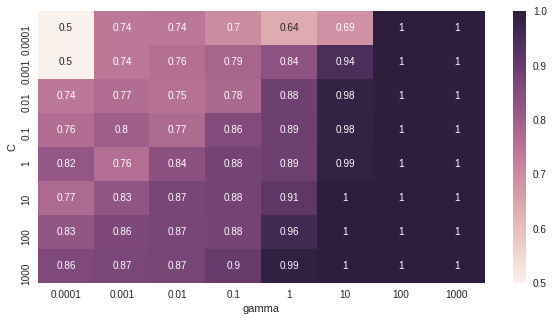

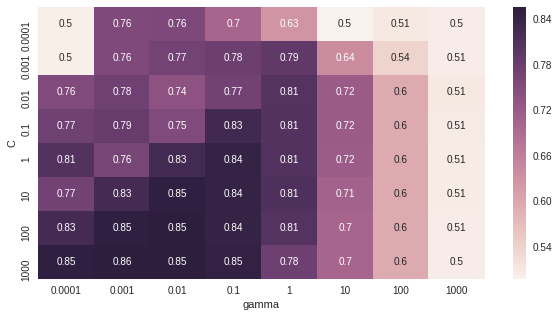

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
gamma=[0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc=[]
cv_auc=[]


for i in C:
  for j in gamma:
      rbfsvm=SVC(C=i,gamma=j,kernel="rbf",random_state=42,probability=True)
      rbfsvm.fit(avgw2v_train,Y_train)
      Y_train_predict=rbfsvm.predict_proba(avgw2v_train)[:,1]
      Y_cv_predict=rbfsvm.predict_proba(avgw2v_cv)[:,1]
      train_auc.append(roc_auc_score(Y_train,Y_train_predict))
      cv_auc.append(roc_auc_score(Y_cv,Y_cv_predict))

print(max(cv_auc))
data=np.array(train_auc)
data=data.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(data,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
cvdata=np.array(cv_auc)
cvdata=cvdata.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(cvdata,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

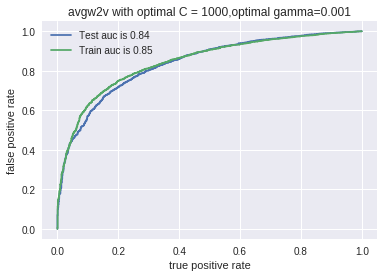

In [62]:
optimal_C=1000
optimal_gamma=0.001
optimalrbfsvm=SVC(C=optimal_C,gamma=optimal_gamma,kernel="rbf",class_weight="balanced",random_state=42,probability=True)
optimalrbfsvm.fit(avgw2v_train,Y_train)

Y_test_proba=optimalrbfsvm.predict_proba(avgw2v_test)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=optimalrbfsvm.predict_proba(avgw2v_train)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)
plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('avgw2v with optimal C = {0},optimal gamma={1}'.format(optimal_C,optimal_gamma))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix for train_data avgw2v for optimal alpha = 1000 optimal gamma=0.001')

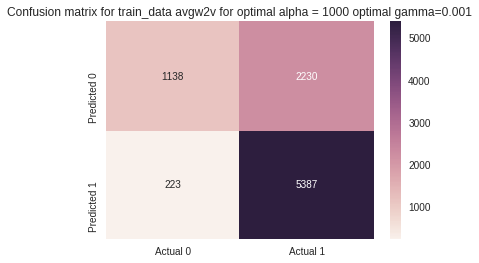

In [63]:
ax = sns.heatmap(confusion_matrix(Y_train,optimalrbfsvm.predict(avgw2v_train)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for train_data avgw2v for optimal alpha = {0} optimal gamma={1}'.format(optimal_C,optimal_gamma))

Text(0.5, 1.0, 'Confusion matrix for test_data avgw2v for optimal alpha = 1000 optimal alpha')

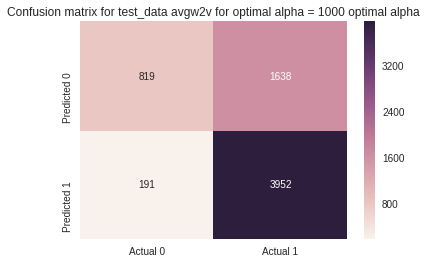

In [64]:
ax = sns.heatmap(confusion_matrix(Y_test,optimalrbfsvm.predict(avgw2v_test)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for test_data avgw2v for optimal alpha = {0} optimal alpha'.format(optimal_C,optimal_gamma))

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [65]:
# Please write all the code with proper documentation
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidfw2v_train=np.array(tfidf_sent_vectors)
print(tfidfw2v_train.shape)
print(tfidfw2v_train[0])


100%|██████████| 8978/8978 [01:31<00:00, 98.05it/s] 

(8978, 50)
[-0.31092398  0.18387181 -0.16607822 -0.37202071 -0.68005553  0.74370452
  0.06682891 -0.00301579 -0.3543389  -0.27163151 -0.71454099 -0.30589963
  0.6322669   0.2728507   0.04809645 -0.2618257  -0.36253442 -0.65648231
 -0.17684573 -0.76635127  0.32898583  0.33776479 -0.15992906 -0.3461688
 -0.41495204  0.05995163  0.40084071  0.02666886 -0.20147092  0.36176973
  0.11934251  0.27495357  0.13802134  0.08468454  0.023581    0.34008808
 -0.1245449   0.03138822 -0.42577269  0.31684338  0.28126724 -0.12953931
 -0.01875859 -0.40779277 -0.73139053  0.08469775 -0.18093963 -0.30476893
  0.08479751  0.34445239]


In [66]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidfw2v_test=np.array(tfidf_sent_vectors)
print(tfidfw2v_test.shape)
print(tfidfw2v_test[0])

100%|██████████| 6600/6600 [01:06<00:00, 99.21it/s] 

(6600, 50)
[-5.82493624e-01  6.48163911e-01  1.28617206e-01 -8.77990640e-02
 -9.53396988e-01  3.74334533e-01 -3.89444761e-01  4.71627830e-02
 -9.89247095e-01  1.10638946e-01 -4.52167930e-01 -1.54749589e-01
 -9.60131204e-04  8.19454467e-01  8.33073955e-02 -6.12373792e-01
 -5.38516258e-01 -1.01815474e+00 -3.25039098e-01  7.28863892e-02
 -5.75318141e-01  3.86371151e-01 -3.19147966e-01  1.01192423e-01
 -5.07348890e-01 -1.38996089e-01  6.45406673e-01 -6.27317024e-01
 -5.01876879e-01 -1.01843060e-01  6.39653483e-01  1.01849182e-01
  2.26579026e-01  2.93044357e-01  4.56958932e-01  4.09392177e-01
 -1.15551498e-01  1.97817963e-01 -8.49493569e-02  5.43685580e-01
 -2.99207613e-01  2.07353044e-01  5.85557964e-01  5.06178323e-01
 -7.23051682e-01  1.00510703e-01 -6.92317603e-01 -3.36867179e-01
  2.85893631e-01  5.07598266e-01]


In [67]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidfw2v_cv=np.array(tfidf_sent_vectors)
print(tfidfw2v_cv.shape)
print(tfidfw2v_cv[0])

100%|██████████| 4422/4422 [00:45<00:00, 98.04it/s]

(4422, 50)
[-0.59799073  0.43722833  0.18119717 -0.35431103 -0.49472624  0.42176044
 -0.06452823  0.04938344 -0.59120711 -0.2059032  -0.57365703 -0.11077314
  0.39421459  0.23866328  0.0183271  -0.63504735 -0.33118578 -0.53458555
 -0.41719412 -0.49042504  0.04178924  0.15418831 -0.26188669 -0.1597449
 -0.60447899  0.02869577  0.25860232 -0.10474896 -0.36162122  0.06675178
  0.1821751   0.29535414  0.34321212 -0.01776122  0.01482537  0.62676026
 -0.07758128  0.145917   -0.41008971  0.38789117  0.1513787  -0.03281065
  0.31684856 -0.12004428 -0.67316151  0.20300479 -0.28106901 -0.10784375
  0.19641109  0.43498024]


0.8330523819315376


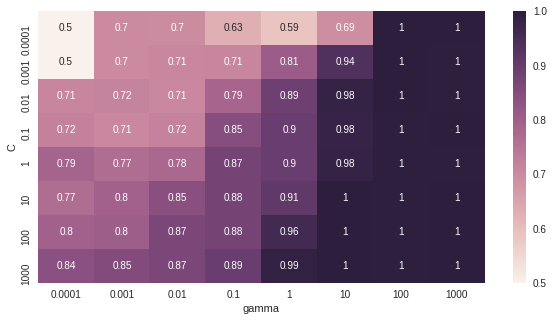

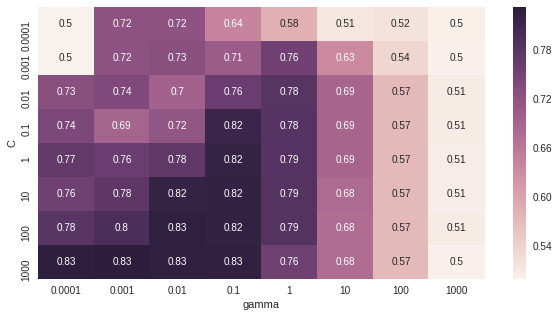

In [68]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
gamma=[0.0001,0.001,0.01,0.1,1,10,100,1000]
train_auc=[]
cv_auc=[]


for i in C:
  for j in gamma:
      rbfsvm=SVC(C=i,gamma=j,kernel="rbf",random_state=42,probability=True)
      rbfsvm.fit(tfidfw2v_train,Y_train)
      Y_train_predict=rbfsvm.predict_proba(tfidfw2v_train)[:,1]
      Y_cv_predict=rbfsvm.predict_proba(tfidfw2v_cv)[:,1]
      train_auc.append(roc_auc_score(Y_train,Y_train_predict))
      cv_auc.append(roc_auc_score(Y_cv,Y_cv_predict))

print(max(cv_auc))
data=np.array(train_auc)
data=data.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(data,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
cvdata=np.array(cv_auc)
cvdata=cvdata.reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(cvdata,annot=True,xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

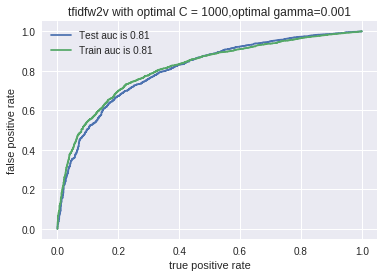

In [70]:
optimal_C=1000
optimal_gamma=0.001
optimalrbfsvm=SVC(C=optimal_C,gamma=optimal_gamma,kernel="rbf",class_weight="balanced",random_state=42,probability=True)
optimalrbfsvm.fit(avgw2v_train,Y_train)

Y_test_proba=optimalrbfsvm.predict_proba(tfidfw2v_test)[:,1]

fpr_test,tpr_test,thresholds=metrics.roc_curve(Y_test,Y_test_proba)

test_auc=metrics.auc(fpr_test,tpr_test)

Y_train_proba=optimalrbfsvm.predict_proba(tfidfw2v_train)[:,1]

fpr_train,tpr_train,thresholds=metrics.roc_curve(Y_train,Y_train_proba)

train_auc=metrics.auc(fpr_train,tpr_train)

plt.plot(fpr_test,tpr_test,label="Test auc is %0.2f"%(test_auc))
plt.plot(fpr_train,tpr_train,label="Train auc is %0.2f"%(train_auc))
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('tfidfw2v with optimal C = {0},optimal gamma={1}'.format(optimal_C,optimal_gamma))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix for train_data tfidfw2v for optimal alpha = 1000 optimal gamma=0.001')

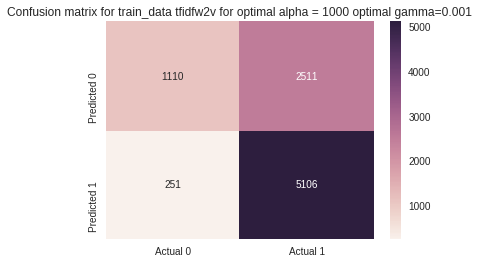

In [72]:
ax = sns.heatmap(confusion_matrix(Y_train,optimalrbfsvm.predict(tfidfw2v_train)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for train_data tfidfw2v for optimal alpha = {0} optimal gamma={1}'.format(optimal_C,optimal_gamma))

Text(0.5, 1.0, 'Confusion matrix for test_data tfidfw2v for optimal alpha = 1000')

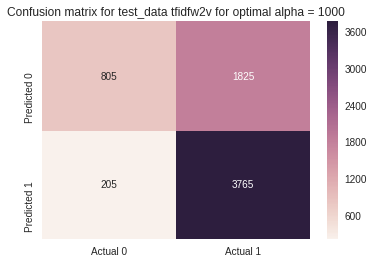

In [74]:
ax = sns.heatmap(confusion_matrix(Y_test,optimalrbfsvm.predict(tfidfw2v_test)).T,yticklabels=["Predicted 0","Predicted 1"],\
                 xticklabels=["Actual 0","Actual 1"],annot = True,fmt='d')
ax.set_title('Confusion matrix for test_data tfidfw2v for optimal alpha = {}'.format(optimal_C,optimal_gamma))

# [6] Conclusions

 SVM is giving good results with BOW and tfidf vectorizers on amazon fine food reviews data with balanced dataset.



1.First I split the Dataset into train,test

2.After that I calculate BOW/TFIDF/avgw2v/tfidfw2v vectors.

3.After that I found optimal_alphha using gridsearchCV which is giving maximum cross validation auc score for linear svm models.

4.After that test the model's performance using test_data and calculate auc_score for train and test dataset.

5.plotted the confusion matrix for both train data and test data

6. I printed the  top features for both positive and negative classes using coef_ for Bow and Tfidf representations for linear svms.

7.for rbf svm I done hyperparameter using simple for loops.

9.At last represented the results using prettytable library.


In [116]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Vectorizer", "optimal_alpha", "AUC"]

x.add_row(["Linear SVM","BOW" ,0.1 ,0.92])
x.add_row(["Linear SVM","TFIDF",0.1,0.91])
x.add_row(["Linear SVM","AVGW2V",0.001,0.90])
x.add_row(["Linear SVM","TFIDFW2V",0.01,0.88])


y = PrettyTable()

y.field_names = ["Model", "Vectorizer", "optimal_C","optimal_gamma","AUC"]

y.add_row(["RBF SVM","BOW" ,1,0.001,0.89])
y.add_row(["RBF SVM","TFIDF",1,0.001,0.89])
y.add_row(["RBF SVM","AVGW2V",1000,0.001,0.84])
y.add_row(["RBF SVM","TFIDFW2V",1000,0.001,0.81])
print(x)
print(y)

+------------+------------+---------------+------+
|   Model    | Vectorizer | optimal_alpha | AUC  |
+------------+------------+---------------+------+
| Linear SVM |    BOW     |      0.1      | 0.92 |
| Linear SVM |   TFIDF    |      0.1      | 0.91 |
| Linear SVM |   AVGW2V   |     0.001     | 0.9  |
| Linear SVM |  TFIDFW2V  |      0.01     | 0.88 |
+------------+------------+---------------+------+
+---------+------------+-----------+---------------+------+
|  Model  | Vectorizer | optimal_C | optimal_gamma | AUC  |
+---------+------------+-----------+---------------+------+
| RBF SVM |    BOW     |     1     |     0.001     | 0.89 |
| RBF SVM |   TFIDF    |     1     |     0.001     | 0.89 |
| RBF SVM |   AVGW2V   |    1000   |     0.001     | 0.84 |
| RBF SVM |  TFIDFW2V  |    1000   |     0.001     | 0.81 |
+---------+------------+-----------+---------------+------+
